# A1 - Proposta de Modelo de Síntese de Dado Tabular em Saúde

#### Aluno: Tiago Amorim (100.675)

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.dates as mdates
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

In [117]:
df_agg = pd.read_csv('./data_agg.csv', parse_dates=['Date'])
# df_agg.head()

In [118]:
columns = df_agg.columns[-7:]
columns

Index(['Age', 'Sex', 'PLAQUETAS SANGUE', 'NEUTRÓFILOS ABSOLUTO',
       'LINFÓCITOS ABSOLUTO', 'NEUTRÓFILOS %', 'LINFÓCITOS %'],
      dtype='object')

# Geração de Amostras com VAE

In [119]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from dataclasses import dataclass

In [120]:
# Baseado em: https://hunterheidenreich.com/posts/modern-variational-autoencoder-in-pytorch/

@dataclass
class VAEOutput:
    """
    Dataclass for VAE output.

    Attributes:
        z_dist (torch.distributions.Distribution): The distribution of the latent variable z.
        z_sample (torch.Tensor): The sampled value of the latent variable z.
        x_recon (torch.Tensor): The reconstructed output from the VAE.
        loss (torch.Tensor): The overall loss of the VAE.

        loss_mse (torch.Tensor): The reconstruction loss MSE component of the VAE loss.
        loss_bin (torch.Tensor): The reconstruction loss binary CE component of the VAE loss.
        loss_recon (torch.Tensor): The reconstruction loss component of the VAE loss.
        loss_kl (torch.Tensor): The KL divergence component of the VAE loss.
    """
    z_dist: torch.distributions.Distribution
    z_sample: torch.Tensor
    x_recon: torch.Tensor

    loss: torch.Tensor

    loss_recon_mse: torch.Tensor
    loss_recon_bin: torch.Tensor
    loss_recon: torch.Tensor
    loss_kl: torch.Tensor


In [121]:
class SigmoidFirstValue(nn.Module):
    def __init__(self):
        super(SigmoidFirstValue, self).__init__()

    def forward(self, x):
        mask = torch.concat((torch.ones_like(x[:,:1]), torch.zeros_like(x[:,1:])), dim=1)
        xs = torch.sigmoid(x) * mask
        return xs + x * (1 - mask)

In [122]:
class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) class.

    Args:
        input_dim (int): Dimensionality of the input data.
        hidden_dim (int): Dimensionality of the hidden layer.
        latent_dim (int): Dimensionality of the latent space.
        beta (float): Weight for the KL divergence term.
        alpha (float): Weight for the MSE loss term.
    """

    def __init__(self, input_dim, hidden_dim, latent_dim, beta=1.0, alpha=0.9, n_hidden_layers=2):
        super(VAE, self).__init__()
        assert n_hidden_layers >= 1, 'Number of hidden layers must be at least 1.'

        self.latent_dim = latent_dim
        self.beta = beta
        self.alpha = alpha

        self.encoder = nn.Sequential()
        self.encoder.add_module('input_linear',nn.Linear(input_dim, hidden_dim))
        self.encoder.add_module('input_act',nn.SiLU())
        for i in range(n_hidden_layers):
            self.encoder.add_module(f'{i+1}_linear',nn.Linear(hidden_dim, hidden_dim))
            self.encoder.add_module(f'{i+1}_act',nn.SiLU())
        self.encoder.add_module('output_linear',nn.Linear(hidden_dim, 2 * latent_dim)) # mean and variance

        self.softplus = nn.Softplus()

        self.decoder = nn.Sequential()
        self.decoder.add_module('input_linear',nn.Linear(latent_dim, hidden_dim))
        self.decoder.add_module('input_act',nn.SiLU())
        for i in range(n_hidden_layers):
            self.decoder.add_module(f'{i+1}_linear',nn.Linear(hidden_dim, hidden_dim))
            self.decoder.add_module(f'{i+1}_act',nn.SiLU())
        self.decoder.add_module('output_linear',nn.Linear(hidden_dim, input_dim))

        self.sigmoid_first_value = SigmoidFirstValue()

    def encode(self, x, eps: float = 1e-8):
        """
        Encodes the input data into the latent space.

        Args:
            x (torch.Tensor): Input data.
            eps (float): Small value to avoid numerical instability.

        Returns:
            torch.distributions.MultivariateNormal: Normal distribution of the encoded data.
        """
        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)

        return torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)

    def reparameterize(self, dist):
        """
        Reparameterizes the encoded data to sample from the latent space.

        Args:
            dist (torch.distributions.MultivariateNormal): Normal distribution of the encoded data.
        Returns:
            torch.Tensor: Sampled data from the latent space.
        """
        return dist.rsample()

    def decode(self, z):
        """
        Decodes the data from the latent space to the original input space.

        Args:
            z (torch.Tensor): Data in the latent space.

        Returns:
            torch.Tensor: Reconstructed data in the original input space.
        """
        x_recon = self.decoder(z)
        x_recon = self.sigmoid_first_value(x_recon)
        return x_recon

    def forward(self, x, compute_loss: bool = True):
        """
        Performs a forward pass of the VAE.

        Args:
            x (torch.Tensor): Input data.
            compute_loss (bool): Whether to compute the loss or not.

        Returns:
            VAEOutput: VAE output dataclass.
        """
        dist = self.encode(x)
        z = self.reparameterize(dist)
        recon_x = self.decode(z)

        if not compute_loss:
            return VAEOutput(
                z_dist=dist,
                z_sample=z,
                x_recon=recon_x,
                loss=None,
                loss_recon_mse=None,
                loss_recon_bin=None,
                loss_recon=None,
                loss_kl=None,
            )

        mask = torch.concat((torch.ones_like(x[:,:1]), torch.zeros_like(x[:,1:])), dim=1)

        loss_recon_bin = F.binary_cross_entropy(recon_x * mask, x * mask, reduction='mean')
        loss_recon_mse = F.mse_loss(recon_x * (1-mask), x * (1-mask), reduction='mean')
        loss_recon = (1 - self.alpha) * loss_recon_bin + self.alpha * loss_recon_mse

        std_normal = torch.distributions.MultivariateNormal(
            torch.zeros_like(z, device=z.device),
            scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1),
        )
        loss_kl = torch.distributions.kl.kl_divergence(dist, std_normal).mean()

        loss = loss_recon + self.beta * loss_kl

        return VAEOutput(
            z_dist=dist,
            z_sample=z,
            x_recon=recon_x,
            loss=loss,
            loss_recon_mse=loss_recon_mse.detach(),
            loss_recon_bin=loss_recon_bin.detach(),
            loss_recon=loss_recon.detach(),
            loss_kl=loss_kl.detach(),
        )

    def samples(self, n_samples = 1):
        """
        Gets samples from the latent space.

        Args:
            n_samples (int): Number of samples to generate.

        Returns:
            torch.Tensor: Samples from the latent space.
        """
        device = next(self.parameters()).device
        z = torch.randn(n_samples, self.latent_dim, device=device)
        return self.decode(z)


## Data Tensors

In [123]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split

In [124]:
columns = list(df_agg.columns[-7:])
columns[0], columns[1] = columns[1], columns[0]
X_values = df_agg[columns].values

log_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1, validate=True)

scaler = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), [0]),
        ('standard', StandardScaler(), [1]),
        ('log', log_transformer, [2 ,3 , 4]),
        ('standard2', StandardScaler(), [5, 6]),
    ],
    remainder='passthrough'
)
X_scaled = scaler.fit_transform(X_values)
X_train_scaled, X_test_scaled = train_test_split(X_scaled, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)

In [125]:
zero_one_scaler = MinMaxScaler().fit(X_scaled)

In [126]:
inv_scaler = []
for i in range(4):
    inv_scaler.append(FunctionTransformer(scaler.transformers_[i][1].inverse_transform, validate=True))

inverse_scaler = ColumnTransformer(
    transformers=[
        ('minmax', inv_scaler[0], [0]),
        ('standard', inv_scaler[1], [1]),
        ('log', inv_scaler[2], [2 ,3 , 4]),
        ('standard2', inv_scaler[3], [5, 6]),
    ],
    remainder='passthrough'
)

x_reversed = inverse_scaler.fit_transform(X_scaled)

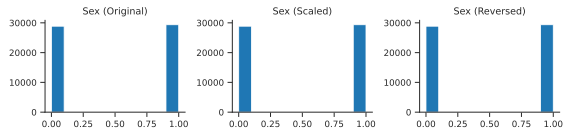

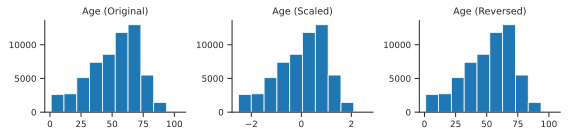

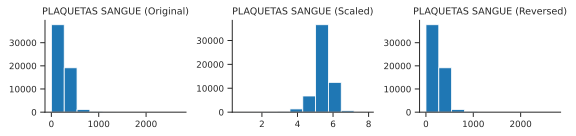

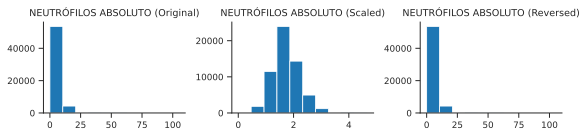

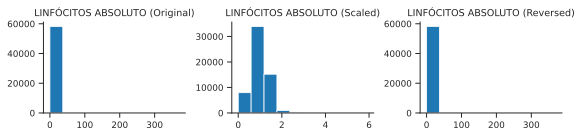

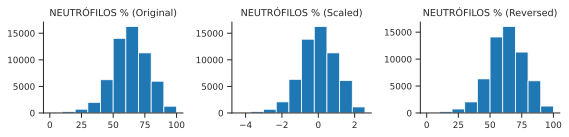

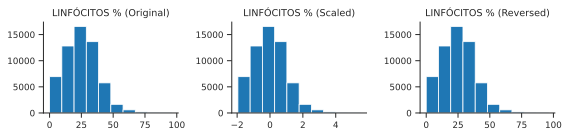

In [127]:
for i in range(X_scaled.shape[1]):
    fig, ax = plt.subplots(1, 3, figsize=(8, 2))
    ax[0].set_title(f'{columns[i]} (Original)')
    ax[0].hist(X_values[:,i])
    ax[1].set_title(f'{columns[i]} (Scaled)')
    ax[1].hist(X_scaled[:,i])
    ax[2].set_title(f'{columns[i]} (Reversed)')
    ax[2].hist(x_reversed[:,i])
    sns.despine()
    plt.tight_layout()
    plt.show()

## Training Functions

In [128]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

In [129]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [130]:
def reconstruction_fig(model, data, inv_scaler, scaled=True):
    model.eval()
    device = next(model.parameters()).device
    with torch.no_grad():
        data = data.to(device)
        output = model(data, compute_loss=False)
        recon = output.x_recon.cpu().numpy()
        recon[:,0] = np.round(recon[:,0], 0)
        data = data.cpu().numpy()

        if not scaled:
            data = inv_scaler.transform(data)
            recon = inv_scaler.transform(recon)
        else:
            data = zero_one_scaler.transform(data)
            recon = zero_one_scaler.transform(recon)

        if len(data.shape) == 1:
            data = data.reshape(1, -1)
            recon = recon.reshape(1, -1)
        recon[:,0] = recon[:,0].round(0) # Sex
        n_samples = data.shape[0]

        fig, ax = plt.subplots(n_samples, 1, figsize=(4, 2*n_samples))
        if n_samples == 1:
            ax = [ax]
        for i in range(n_samples):
            ax[i].plot(data[i], label='Original', color='blue', marker='o')
            ax[i].plot(recon[i], label='Reconstructed', color='blue', marker='o', linestyle='--')
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            if not scaled:
                ax[i].set_ylim(0, 1)
        ax[0].legend()
        plt.tight_layout()
        return fig

def density_fig(model, data, inv_scaler, scaled=True):
    model.eval()
    with torch.no_grad():
        samples = model.samples(10000).to('cpu').detach().numpy()
        data = data.cpu().numpy()

        if not scaled:
            samples = inv_scaler.transform(samples)
            data = inv_scaler.transform(data)

        if len(data.shape) == 1:
            data = data.reshape(1, -1)
            recon = recon.reshape(1, -1)
        n_plots = data.shape[1]

        fig, ax = plt.subplots(n_plots, 1, figsize=(4, 2*n_plots))
        if n_plots == 1:
            ax = [ax]
        for i in range(n_plots):
            sns.kdeplot(data[:,i], label='Original', ax=ax[i], bw_adjust=0.5, color='blue')
            sns.kdeplot(samples[:,i], label='Synthetic', ax=ax[i], bw_adjust=0.5, color='blue', linestyle='--')
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            ax[i].set_ylabel(columns[i])
        ax[0].legend()
        plt.tight_layout()
        return fig

In [131]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    """
    Trains the model on the given data.

    Args:
        model (nn.Module): The model to train.
        dataloader (torch.utils.data.DataLoader): The data loader.
        loss_fn: The loss function.
        optimizer: The optimizer.
    """
    model.train()  # Set the model to training mode
    device = next(model.parameters()).device
    batch_size = dataloader.batch_size

    for batch_idx, data in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx

        data = data.to(device)
        optimizer.zero_grad()  # Zero the gradients
        output = model(data)  # Forward pass
        loss = output.loss
        loss.backward(retain_graph=True)

        if n_upd % 100 == 0:
            # Calculate and log gradient norms
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)

            # print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon Bin: {output.loss_recon_bin.item():.4f}, Recon MSE: {output.loss_recon_mse.item():.4f}, Recon: {output.loss_recon.item():.4f}, KL: {output.loss_kl.item():.4f}) Grad: {total_norm:.4f}')
            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {output.loss_recon.item():.4f}, KL: {output.loss_kl.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', output.loss_kl.item(), global_step)
                writer.add_scalar('Loss/Train/Recon', output.loss_recon.item(), global_step)
                writer.add_scalar('Loss/Train/BCE', output.loss_recon_bin.item(), global_step)
                writer.add_scalar('Loss/Train/MSE', output.loss_recon_mse.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()  # Update the model parameters

    return prev_updates + len(dataloader)

In [132]:
def test(model, dataloader, cur_step, writer=None):
    """
    Tests the model on the given data.

    Args:
        model (nn.Module): The model to test.
        dataloader (torch.utils.data.DataLoader): The data loader.
        cur_step (int): The current step.
        writer: The TensorBoard writer.
    """
    device = next(model.parameters()).device

    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0

    with torch.no_grad():
        for data in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            data = data.view(data.size(0), -1)  # Flatten the data

            output = model(data, compute_loss=True)  # Forward pass

            test_loss += output.loss.item()
            test_recon_loss += output.loss_recon.item()
            test_kl_loss += output.loss_kl.item()

    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    print(f'====> Test set loss: {test_loss:.4f} (Recon: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f})')

    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/Recon', output.loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', output.loss_kl.item(), global_step=cur_step)

        inputs = next(iter(dataloader))
        writer.add_figure('Plots/Reconstruction', reconstruction_fig(model, inputs[:5], inverse_scaler, scaled=True), global_step=cur_step)
        all_samples = []
        for batch in dataloader:
            all_samples.append(batch)
        inputs = torch.cat(all_samples, dim=0)
        writer.add_figure('Plots/Density', density_fig(model, inputs, inverse_scaler, scaled=True), global_step=cur_step)

    return test_loss, test_recon_loss, test_kl_loss


In [133]:
def get_dataloaders(batch_size, X_train, X_test):
    train_loader = torch.utils.data.DataLoader(
        X_train,
        batch_size=batch_size,
        shuffle=True,
    )
    test_loader = torch.utils.data.DataLoader(
        X_test,
        batch_size=batch_size,
        shuffle=False,
    )
    return train_loader, test_loader


def build_vae(options):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = VAE(
        input_dim=7,
        hidden_dim=options['hidden_dim'],
        latent_dim=options['latent_dim'],
        beta=options['beta'],
        alpha=options['alpha'],
        n_hidden_layers=options['n_hidden_layers']
        ).to(device)
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=options['learning_rate'],
        weight_decay=options['weight_decay'])
    model_name = f'{options["study_name"]}/vae_{datetime.now().strftime("%Y%m%d-%H%M%S")}'
    writer = SummaryWriter(f'runs/{model_name}')
    print(f"Model name: {model_name}")
    return model, optimizer, writer


def train_vae(options, model, optimizer, writer, train_loader, test_loader):
    prev_updates = 0
    best_loss = float('inf')
    best_losses = {}

    for epoch in range(options['num_epochs']):
        print(f'Epoch {epoch+1}/{options["num_epochs"]}')
        prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
        test_loss, test_recon_loss, test_kl_loss = test(model, test_loader, prev_updates, writer=writer)
        if test_loss < best_loss:
            best_loss = test_loss
            best_losses = {
                'hparam/test_loss': test_loss,
                'hparam/recon_loss': test_recon_loss,
                'hparam/kl_loss': test_kl_loss,
            }
    writer.add_hparams(options, best_losses)
    writer.flush()
    writer.close()


def run_vae(options, X_train, X_test):
    model, optimizer, writer = build_vae(options)
    print(f"Number of parameters in the model: {count_parameters(model)}")

    train_loader, test_loader = get_dataloaders(options['batch_size'], X_train, X_test)
    train_vae(options, model, optimizer, writer, train_loader, test_loader)
    return model

## Model Training

In [134]:
options = {
    'batch_size': 128,
    'learning_rate': 1e-4,
    'weight_decay': 1e-2,
    'num_epochs': 50,
    'latent_dim': 5,
    'hidden_dim': 12,
    'n_hidden_layers': 4,
    'beta': 0.01,
    'alpha': 0.80,
    'study_name': 'vae06',
    }

model = run_vae(options, X_train, X_test)

Model name: vae06/vae_20240903-105253
Number of parameters in the model: 1637
Epoch 1/50


  1%|          | 3/365 [00:00<00:12, 28.21it/s]

Step 0 (N samples: 0), Loss: 3.9181 (Recon: 3.9122, KL: 0.5938) Grad: 1.3749


 34%|███▎      | 123/365 [00:01<00:01, 156.46it/s]

Step 100 (N samples: 12,800), Loss: 3.7562 (Recon: 3.7510, KL: 0.5163) Grad: 1.3802


 61%|██████    | 222/365 [00:01<00:00, 154.24it/s]

Step 200 (N samples: 25,600), Loss: 3.8035 (Recon: 3.7990, KL: 0.4529) Grad: 1.4119


 88%|████████▊ | 321/365 [00:02<00:00, 163.80it/s]

Step 300 (N samples: 38,400), Loss: 3.5806 (Recon: 3.5765, KL: 0.4077) Grad: 1.4203


Testing: 100%|██████████| 92/92 [00:00<00:00, 336.05it/s]


====> Test set loss: 3.6031 (Recon: 3.5990, KLD: 0.4115)
Epoch 2/50


 18%|█▊        | 67/365 [00:00<00:02, 135.20it/s]

Step 400 (N samples: 51,200), Loss: 3.4147 (Recon: 3.4097, KL: 0.4977) Grad: 1.4892


 42%|████▏     | 154/365 [00:01<00:01, 163.95it/s]

Step 500 (N samples: 64,000), Loss: 3.0691 (Recon: 3.0170, KL: 5.2103) Grad: 2.5346


 71%|███████   | 259/365 [00:01<00:00, 170.30it/s]

Step 600 (N samples: 76,800), Loss: 1.5776 (Recon: 1.2842, KL: 29.3426) Grad: 4.8589


100%|██████████| 365/365 [00:02<00:00, 149.01it/s]


Step 700 (N samples: 89,600), Loss: 0.7842 (Recon: 0.5280, KL: 25.6160) Grad: 1.4301


Testing: 100%|██████████| 92/92 [00:00<00:00, 314.34it/s]


====> Test set loss: 0.6804 (Recon: 0.4876, KLD: 19.2819)
Epoch 3/50


 25%|██▍       | 90/365 [00:00<00:02, 119.64it/s]

Step 800 (N samples: 102,400), Loss: 0.5684 (Recon: 0.4340, KL: 13.4392) Grad: 0.5025


 55%|█████▍    | 200/365 [00:01<00:01, 151.64it/s]

Step 900 (N samples: 115,200), Loss: 0.5450 (Recon: 0.4357, KL: 10.9360) Grad: 0.4794


 81%|████████  | 296/365 [00:02<00:00, 149.92it/s]

Step 1,000 (N samples: 128,000), Loss: 0.5002 (Recon: 0.4079, KL: 9.2226) Grad: 0.4322


Testing: 100%|██████████| 92/92 [00:00<00:00, 328.74it/s]


====> Test set loss: 0.5177 (Recon: 0.4327, KLD: 8.5018)
Epoch 4/50


  1%|▏         | 5/365 [00:00<00:07, 49.27it/s]

Step 1,100 (N samples: 140,800), Loss: 0.5222 (Recon: 0.4387, KL: 8.3463) Grad: 0.2993


 37%|███▋      | 136/365 [00:01<00:01, 150.68it/s]

Step 1,200 (N samples: 153,600), Loss: 0.5087 (Recon: 0.4305, KL: 7.8136) Grad: 0.1457


 64%|██████▍   | 234/365 [00:01<00:00, 148.73it/s]

Step 1,300 (N samples: 166,400), Loss: 0.4838 (Recon: 0.4093, KL: 7.4491) Grad: 0.1658


 91%|█████████ | 332/365 [00:02<00:00, 152.77it/s]

Step 1,400 (N samples: 179,200), Loss: 0.5017 (Recon: 0.4308, KL: 7.0910) Grad: 0.2243


Testing: 100%|██████████| 92/92 [00:00<00:00, 337.44it/s]


====> Test set loss: 0.4906 (Recon: 0.4228, KLD: 6.7759)
Epoch 5/50


 16%|█▌        | 58/365 [00:00<00:02, 118.69it/s]

Step 1,500 (N samples: 192,000), Loss: 0.4790 (Recon: 0.4108, KL: 6.8160) Grad: 0.4462


 43%|████▎     | 158/365 [00:01<00:01, 159.25it/s]

Step 1,600 (N samples: 204,800), Loss: 0.5060 (Recon: 0.4420, KL: 6.4003) Grad: 0.1562


 71%|███████   | 259/365 [00:01<00:00, 156.51it/s]

Step 1,700 (N samples: 217,600), Loss: 0.4309 (Recon: 0.3694, KL: 6.1474) Grad: 0.5343


100%|██████████| 365/365 [00:02<00:00, 141.71it/s]


Step 1,800 (N samples: 230,400), Loss: 0.3737 (Recon: 0.3146, KL: 5.9194) Grad: 0.4626


Testing: 100%|██████████| 92/92 [00:00<00:00, 333.12it/s]


====> Test set loss: 0.4731 (Recon: 0.4140, KLD: 5.9162)
Epoch 6/50


 29%|██▉       | 105/365 [00:00<00:01, 141.55it/s]

Step 1,900 (N samples: 243,200), Loss: 0.4661 (Recon: 0.4085, KL: 5.7623) Grad: 0.5766


 56%|█████▋    | 206/365 [00:01<00:00, 160.33it/s]

Step 2,000 (N samples: 256,000), Loss: 0.5185 (Recon: 0.4614, KL: 5.7173) Grad: 0.4743


 84%|████████▍ | 308/365 [00:02<00:00, 162.04it/s]

Step 2,100 (N samples: 268,800), Loss: 0.5312 (Recon: 0.4754, KL: 5.5824) Grad: 0.4123


Testing: 100%|██████████| 92/92 [00:00<00:00, 334.85it/s]


====> Test set loss: 0.4645 (Recon: 0.4111, KLD: 5.3425)
Epoch 7/50


  5%|▍         | 18/365 [00:00<00:06, 57.22it/s]

Step 2,200 (N samples: 281,600), Loss: 0.4820 (Recon: 0.4303, KL: 5.1738) Grad: 0.4006


 36%|███▌      | 130/365 [00:01<00:01, 145.22it/s]

Step 2,300 (N samples: 294,400), Loss: 0.4628 (Recon: 0.4098, KL: 5.2988) Grad: 0.2031


 63%|██████▎   | 231/365 [00:01<00:00, 151.49it/s]

Step 2,400 (N samples: 307,200), Loss: 0.4840 (Recon: 0.4326, KL: 5.1383) Grad: 0.4270


 90%|████████▉ | 328/365 [00:02<00:00, 146.78it/s]

Step 2,500 (N samples: 320,000), Loss: 0.4461 (Recon: 0.3964, KL: 4.9646) Grad: 0.4258


Testing: 100%|██████████| 92/92 [00:00<00:00, 328.31it/s]


====> Test set loss: 0.4571 (Recon: 0.4074, KLD: 4.9628)
Epoch 8/50


 18%|█▊        | 64/365 [00:00<00:02, 114.90it/s]

Step 2,600 (N samples: 332,800), Loss: 0.4967 (Recon: 0.4496, KL: 4.7091) Grad: 0.3844


 48%|████▊     | 176/365 [00:01<00:01, 149.58it/s]

Step 2,700 (N samples: 345,600), Loss: 0.4776 (Recon: 0.4311, KL: 4.6524) Grad: 0.2593


 74%|███████▎  | 269/365 [00:02<00:00, 151.23it/s]

Step 2,800 (N samples: 358,400), Loss: 0.5271 (Recon: 0.4808, KL: 4.6317) Grad: 0.4466


100%|██████████| 365/365 [00:02<00:00, 134.90it/s]


Step 2,900 (N samples: 371,200), Loss: 0.4257 (Recon: 0.3806, KL: 4.5094) Grad: 0.2938


Testing: 100%|██████████| 92/92 [00:00<00:00, 329.02it/s]


====> Test set loss: 0.4511 (Recon: 0.4055, KLD: 4.5629)
Epoch 9/50


 29%|██▉       | 106/365 [00:01<00:02, 127.03it/s]

Step 3,000 (N samples: 384,000), Loss: 0.4523 (Recon: 0.4081, KL: 4.4190) Grad: 0.2259


 56%|█████▌    | 203/365 [00:01<00:01, 152.71it/s]

Step 3,100 (N samples: 396,800), Loss: 0.4292 (Recon: 0.3844, KL: 4.4813) Grad: 0.4428


 82%|████████▏ | 298/365 [00:02<00:00, 150.48it/s]

Step 3,200 (N samples: 409,600), Loss: 0.5077 (Recon: 0.4665, KL: 4.1262) Grad: 0.3107


Testing: 100%|██████████| 92/92 [00:00<00:00, 325.50it/s]


====> Test set loss: 0.4432 (Recon: 0.4015, KLD: 4.1609)
Epoch 10/50


 13%|█▎        | 46/365 [00:00<00:02, 110.28it/s]

Step 3,300 (N samples: 422,400), Loss: 0.5162 (Recon: 0.4728, KL: 4.3442) Grad: 0.3292


 38%|███▊      | 138/365 [00:01<00:01, 140.32it/s]

Step 3,400 (N samples: 435,200), Loss: 0.4662 (Recon: 0.4261, KL: 4.0157) Grad: 0.2250


 65%|██████▌   | 238/365 [00:01<00:00, 160.77it/s]

Step 3,500 (N samples: 448,000), Loss: 0.4828 (Recon: 0.4414, KL: 4.1418) Grad: 0.5616


 92%|█████████▏| 334/365 [00:02<00:00, 143.78it/s]

Step 3,600 (N samples: 460,800), Loss: 0.4449 (Recon: 0.4059, KL: 3.9016) Grad: 0.2768


Testing: 100%|██████████| 92/92 [00:00<00:00, 343.07it/s]


====> Test set loss: 0.4345 (Recon: 0.3971, KLD: 3.7360)
Epoch 11/50


 23%|██▎       | 83/365 [00:00<00:02, 131.06it/s]

Step 3,700 (N samples: 473,600), Loss: 0.5148 (Recon: 0.4771, KL: 3.7698) Grad: 0.1996


 50%|████▉     | 181/365 [00:01<00:01, 154.31it/s]

Step 3,800 (N samples: 486,400), Loss: 0.4560 (Recon: 0.4214, KL: 3.4662) Grad: 0.2632


 73%|███████▎  | 267/365 [00:01<00:00, 157.28it/s]

Step 3,900 (N samples: 499,200), Loss: 0.3652 (Recon: 0.3297, KL: 3.5503) Grad: 0.2496


100%|██████████| 365/365 [00:02<00:00, 139.65it/s]


Step 4,000 (N samples: 512,000), Loss: 0.4665 (Recon: 0.4332, KL: 3.3251) Grad: 0.1893


Testing: 100%|██████████| 92/92 [00:00<00:00, 309.71it/s]


====> Test set loss: 0.4223 (Recon: 0.3881, KLD: 3.4239)
Epoch 12/50


 28%|██▊       | 103/365 [00:00<00:01, 139.89it/s]

Step 4,100 (N samples: 524,800), Loss: 0.3638 (Recon: 0.3302, KL: 3.3632) Grad: 0.1761


 59%|█████▉    | 215/365 [00:01<00:00, 155.10it/s]

Step 4,200 (N samples: 537,600), Loss: 0.4264 (Recon: 0.3930, KL: 3.3392) Grad: 0.3319


 87%|████████▋ | 316/365 [00:02<00:00, 159.25it/s]

Step 4,300 (N samples: 550,400), Loss: 0.4129 (Recon: 0.3822, KL: 3.0677) Grad: 0.5961


Testing: 100%|██████████| 92/92 [00:00<00:00, 327.94it/s]


====> Test set loss: 0.4061 (Recon: 0.3750, KLD: 3.1156)
Epoch 13/50


  9%|▉         | 34/365 [00:00<00:04, 71.96it/s]

Step 4,400 (N samples: 563,200), Loss: 0.5221 (Recon: 0.4900, KL: 3.2141) Grad: 0.3059


 41%|████      | 148/365 [00:01<00:01, 151.54it/s]

Step 4,500 (N samples: 576,000), Loss: 0.4210 (Recon: 0.3914, KL: 2.9644) Grad: 0.0968


 67%|██████▋   | 243/365 [00:01<00:00, 141.35it/s]

Step 4,600 (N samples: 588,800), Loss: 0.3457 (Recon: 0.3156, KL: 3.0190) Grad: 0.1605


 94%|█████████▎| 342/365 [00:02<00:00, 159.24it/s]

Step 4,700 (N samples: 601,600), Loss: 0.3976 (Recon: 0.3674, KL: 3.0208) Grad: 0.2528


Testing: 100%|██████████| 92/92 [00:00<00:00, 339.13it/s]


====> Test set loss: 0.3815 (Recon: 0.3515, KLD: 2.9972)
Epoch 14/50


 21%|██▏       | 78/365 [00:00<00:02, 137.16it/s]

Step 4,800 (N samples: 614,400), Loss: 0.4073 (Recon: 0.3776, KL: 2.9754) Grad: 0.1954


 50%|████▉     | 182/365 [00:01<00:01, 146.07it/s]

Step 4,900 (N samples: 627,200), Loss: 0.3636 (Recon: 0.3339, KL: 2.9686) Grad: 0.3441


 75%|███████▍  | 272/365 [00:02<00:00, 144.28it/s]

Step 5,000 (N samples: 640,000), Loss: 0.3333 (Recon: 0.3043, KL: 2.9063) Grad: 0.4260


100%|██████████| 365/365 [00:02<00:00, 134.98it/s]


Step 5,100 (N samples: 652,800), Loss: 0.3368 (Recon: 0.3101, KL: 2.6674) Grad: 0.3042


Testing: 100%|██████████| 92/92 [00:00<00:00, 308.11it/s]


====> Test set loss: 0.3450 (Recon: 0.3155, KLD: 2.9438)
Epoch 15/50


 32%|███▏      | 117/365 [00:01<00:01, 138.04it/s]

Step 5,200 (N samples: 665,600), Loss: 0.4218 (Recon: 0.3938, KL: 2.7946) Grad: 0.5335


 57%|█████▋    | 208/365 [00:01<00:01, 146.12it/s]

Step 5,300 (N samples: 678,400), Loss: 0.3098 (Recon: 0.2782, KL: 3.1568) Grad: 0.4630


 87%|████████▋ | 319/365 [00:02<00:00, 151.63it/s]

Step 5,400 (N samples: 691,200), Loss: 0.3052 (Recon: 0.2765, KL: 2.8708) Grad: 0.3195


Testing: 100%|██████████| 92/92 [00:00<00:00, 305.22it/s]


====> Test set loss: 0.3137 (Recon: 0.2852, KLD: 2.8561)
Epoch 16/50


 12%|█▏        | 42/365 [00:00<00:03, 95.95it/s]

Step 5,500 (N samples: 704,000), Loss: 0.3082 (Recon: 0.2792, KL: 2.9079) Grad: 0.2399


 41%|████      | 148/365 [00:01<00:01, 141.74it/s]

Step 5,600 (N samples: 716,800), Loss: 0.2985 (Recon: 0.2710, KL: 2.7555) Grad: 0.3398


 69%|██████▉   | 253/365 [00:01<00:00, 143.71it/s]

Step 5,700 (N samples: 729,600), Loss: 0.3147 (Recon: 0.2889, KL: 2.5724) Grad: 0.2069


 94%|█████████▍| 344/365 [00:02<00:00, 144.00it/s]

Step 5,800 (N samples: 742,400), Loss: 0.2919 (Recon: 0.2634, KL: 2.8473) Grad: 0.3619


Testing: 100%|██████████| 92/92 [00:00<00:00, 310.43it/s]


====> Test set loss: 0.2869 (Recon: 0.2594, KLD: 2.7531)
Epoch 17/50


 22%|██▏       | 80/365 [00:00<00:02, 125.09it/s]

Step 5,900 (N samples: 755,200), Loss: 0.2720 (Recon: 0.2458, KL: 2.6155) Grad: 0.2632


 51%|█████     | 186/365 [00:01<00:01, 142.86it/s]

Step 6,000 (N samples: 768,000), Loss: 0.2733 (Recon: 0.2505, KL: 2.2796) Grad: 0.2910


 78%|███████▊  | 283/365 [00:02<00:00, 150.17it/s]

Step 6,100 (N samples: 780,800), Loss: 0.3012 (Recon: 0.2764, KL: 2.4790) Grad: 0.2962


100%|██████████| 365/365 [00:02<00:00, 131.13it/s]


Step 6,200 (N samples: 793,600), Loss: 0.2951 (Recon: 0.2676, KL: 2.7454) Grad: 0.4044


Testing: 100%|██████████| 92/92 [00:00<00:00, 331.06it/s]


====> Test set loss: 0.2667 (Recon: 0.2410, KLD: 2.5675)
Epoch 18/50


 33%|███▎      | 120/365 [00:01<00:01, 149.52it/s]

Step 6,300 (N samples: 806,400), Loss: 0.2600 (Recon: 0.2363, KL: 2.3635) Grad: 0.3003


 60%|█████▉    | 218/365 [00:01<00:00, 154.13it/s]

Step 6,400 (N samples: 819,200), Loss: 0.3209 (Recon: 0.2960, KL: 2.4900) Grad: 0.2588


 86%|████████▋ | 315/365 [00:02<00:00, 155.22it/s]

Step 6,500 (N samples: 832,000), Loss: 0.2945 (Recon: 0.2723, KL: 2.2173) Grad: 0.2282


Testing: 100%|██████████| 92/92 [00:00<00:00, 325.30it/s]


====> Test set loss: 0.2498 (Recon: 0.2267, KLD: 2.3101)
Epoch 19/50


 13%|█▎        | 49/365 [00:00<00:02, 110.05it/s]

Step 6,600 (N samples: 844,800), Loss: 0.2434 (Recon: 0.2198, KL: 2.3655) Grad: 0.2886


 41%|████      | 148/365 [00:01<00:01, 154.74it/s]

Step 6,700 (N samples: 857,600), Loss: 0.2453 (Recon: 0.2225, KL: 2.2852) Grad: 0.2081


 72%|███████▏  | 262/365 [00:01<00:00, 157.79it/s]

Step 6,800 (N samples: 870,400), Loss: 0.2222 (Recon: 0.1985, KL: 2.3711) Grad: 0.3672


 99%|█████████▊| 360/365 [00:02<00:00, 157.66it/s]

Step 6,900 (N samples: 883,200), Loss: 0.2124 (Recon: 0.1899, KL: 2.2471) Grad: 0.1980


Testing: 100%|██████████| 92/92 [00:00<00:00, 323.31it/s]


====> Test set loss: 0.2381 (Recon: 0.2161, KLD: 2.1955)
Epoch 20/50


 25%|██▍       | 91/365 [00:00<00:02, 128.80it/s]

Step 7,000 (N samples: 896,000), Loss: 0.2599 (Recon: 0.2384, KL: 2.1540) Grad: 0.3100


 51%|█████     | 186/365 [00:01<00:01, 149.96it/s]

Step 7,100 (N samples: 908,800), Loss: 0.2483 (Recon: 0.2254, KL: 2.2869) Grad: 0.4307


 81%|████████▏ | 297/365 [00:02<00:00, 154.23it/s]

Step 7,200 (N samples: 921,600), Loss: 0.2534 (Recon: 0.2306, KL: 2.2886) Grad: 0.1648


Testing: 100%|██████████| 92/92 [00:00<00:00, 313.51it/s]


====> Test set loss: 0.2309 (Recon: 0.2092, KLD: 2.1681)
Epoch 21/50


  1%|          | 4/365 [00:00<00:09, 38.60it/s]

Step 7,300 (N samples: 934,400), Loss: 0.2836 (Recon: 0.2612, KL: 2.2366) Grad: 0.4000


 33%|███▎      | 119/365 [00:01<00:01, 137.17it/s]

Step 7,400 (N samples: 947,200), Loss: 0.2269 (Recon: 0.2050, KL: 2.1880) Grad: 0.7276


 64%|██████▎   | 232/365 [00:01<00:00, 152.32it/s]

Step 7,500 (N samples: 960,000), Loss: 0.2063 (Recon: 0.1855, KL: 2.0736) Grad: 0.6536


 90%|█████████ | 330/365 [00:02<00:00, 155.67it/s]

Step 7,600 (N samples: 972,800), Loss: 0.2162 (Recon: 0.1948, KL: 2.1321) Grad: 0.1956


Testing: 100%|██████████| 92/92 [00:00<00:00, 321.36it/s]


====> Test set loss: 0.2252 (Recon: 0.2037, KLD: 2.1528)
Epoch 22/50


 16%|█▌        | 58/365 [00:00<00:02, 113.95it/s]

Step 7,700 (N samples: 985,600), Loss: 0.2128 (Recon: 0.1918, KL: 2.0910) Grad: 0.2829


 42%|████▏     | 152/365 [00:01<00:01, 145.56it/s]

Step 7,800 (N samples: 998,400), Loss: 0.2437 (Recon: 0.2221, KL: 2.1566) Grad: 0.2902


 72%|███████▏  | 263/365 [00:02<00:00, 152.50it/s]

Step 7,900 (N samples: 1,011,200), Loss: 0.2381 (Recon: 0.2162, KL: 2.1859) Grad: 0.2414


 98%|█████████▊| 356/365 [00:02<00:00, 148.39it/s]

Step 8,000 (N samples: 1,024,000), Loss: 0.2333 (Recon: 0.2123, KL: 2.1002) Grad: 0.1830


Testing: 100%|██████████| 92/92 [00:00<00:00, 303.73it/s]


====> Test set loss: 0.2213 (Recon: 0.2001, KLD: 2.1157)
Epoch 23/50


 24%|██▍       | 89/365 [00:00<00:02, 130.66it/s]

Step 8,100 (N samples: 1,036,800), Loss: 0.2189 (Recon: 0.1968, KL: 2.2112) Grad: 0.1376


 54%|█████▎    | 196/365 [00:01<00:01, 147.45it/s]

Step 8,200 (N samples: 1,049,600), Loss: 0.2152 (Recon: 0.1938, KL: 2.1378) Grad: 0.2244


 79%|███████▉  | 288/365 [00:02<00:00, 147.76it/s]

Step 8,300 (N samples: 1,062,400), Loss: 0.2704 (Recon: 0.2492, KL: 2.1220) Grad: 0.4287


Testing: 100%|██████████| 92/92 [00:00<00:00, 297.80it/s]


====> Test set loss: 0.2184 (Recon: 0.1973, KLD: 2.1107)
Epoch 24/50


  1%|▏         | 5/365 [00:00<00:08, 44.75it/s]

Step 8,400 (N samples: 1,075,200), Loss: 0.2207 (Recon: 0.1997, KL: 2.1023) Grad: 0.2560


 33%|███▎      | 119/365 [00:01<00:01, 134.08it/s]

Step 8,500 (N samples: 1,088,000), Loss: 0.2220 (Recon: 0.2013, KL: 2.0757) Grad: 0.2473


 60%|██████    | 219/365 [00:01<00:01, 134.80it/s]

Step 8,600 (N samples: 1,100,800), Loss: 0.2029 (Recon: 0.1818, KL: 2.1102) Grad: 0.2580


 88%|████████▊ | 322/365 [00:02<00:00, 145.16it/s]

Step 8,700 (N samples: 1,113,600), Loss: 0.2360 (Recon: 0.2148, KL: 2.1263) Grad: 0.3299


Testing: 100%|██████████| 92/92 [00:00<00:00, 335.93it/s]


====> Test set loss: 0.2163 (Recon: 0.1954, KLD: 2.0848)
Epoch 25/50


 20%|█▉        | 72/365 [00:00<00:02, 128.57it/s]

Step 8,800 (N samples: 1,126,400), Loss: 0.2062 (Recon: 0.1857, KL: 2.0544) Grad: 0.2998


 45%|████▍     | 163/365 [00:01<00:01, 141.50it/s]

Step 8,900 (N samples: 1,139,200), Loss: 0.2077 (Recon: 0.1867, KL: 2.0950) Grad: 0.2080


 75%|███████▍  | 272/365 [00:02<00:00, 153.19it/s]

Step 9,000 (N samples: 1,152,000), Loss: 0.2214 (Recon: 0.1999, KL: 2.1489) Grad: 0.2023


100%|██████████| 365/365 [00:02<00:00, 133.51it/s]


Step 9,100 (N samples: 1,164,800), Loss: 0.2614 (Recon: 0.2403, KL: 2.1035) Grad: 0.2565


Testing: 100%|██████████| 92/92 [00:00<00:00, 330.31it/s]


====> Test set loss: 0.2148 (Recon: 0.1939, KLD: 2.0950)
Epoch 26/50


 25%|██▌       | 92/365 [00:00<00:01, 137.83it/s]

Step 9,200 (N samples: 1,177,600), Loss: 0.2291 (Recon: 0.2085, KL: 2.0640) Grad: 0.3296


 53%|█████▎    | 194/365 [00:01<00:01, 129.72it/s]

Step 9,300 (N samples: 1,190,400), Loss: 0.2328 (Recon: 0.2126, KL: 2.0155) Grad: 0.1472


 83%|████████▎ | 302/365 [00:02<00:00, 148.66it/s]

Step 9,400 (N samples: 1,203,200), Loss: 0.2061 (Recon: 0.1854, KL: 2.0719) Grad: 0.2890


Testing: 100%|██████████| 92/92 [00:00<00:00, 326.34it/s]


====> Test set loss: 0.2138 (Recon: 0.1929, KLD: 2.0848)
Epoch 27/50


  5%|▌         | 20/365 [00:00<00:08, 42.30it/s]

Step 9,500 (N samples: 1,216,000), Loss: 0.2281 (Recon: 0.2074, KL: 2.0759) Grad: 0.2467


 39%|███▉      | 142/365 [00:01<00:01, 147.48it/s]

Step 9,600 (N samples: 1,228,800), Loss: 0.2172 (Recon: 0.1966, KL: 2.0594) Grad: 0.3851


 65%|██████▌   | 238/365 [00:01<00:00, 153.31it/s]

Step 9,700 (N samples: 1,241,600), Loss: 0.2068 (Recon: 0.1870, KL: 1.9779) Grad: 0.1249


 92%|█████████▏| 335/365 [00:02<00:00, 151.78it/s]

Step 9,800 (N samples: 1,254,400), Loss: 0.2216 (Recon: 0.2005, KL: 2.1136) Grad: 0.2787


Testing: 100%|██████████| 92/92 [00:00<00:00, 326.73it/s]


====> Test set loss: 0.2130 (Recon: 0.1925, KLD: 2.0515)
Epoch 28/50


 16%|█▋        | 60/365 [00:00<00:02, 114.67it/s]

Step 9,900 (N samples: 1,267,200), Loss: 0.1968 (Recon: 0.1763, KL: 2.0454) Grad: 0.2286


 48%|████▊     | 175/365 [00:01<00:01, 157.72it/s]

Step 10,000 (N samples: 1,280,000), Loss: 0.2010 (Recon: 0.1806, KL: 2.0408) Grad: 0.2876


 75%|███████▌  | 275/365 [00:02<00:00, 155.24it/s]

Step 10,100 (N samples: 1,292,800), Loss: 0.2026 (Recon: 0.1821, KL: 2.0492) Grad: 0.1755


100%|██████████| 365/365 [00:02<00:00, 140.87it/s]


Step 10,200 (N samples: 1,305,600), Loss: 0.2309 (Recon: 0.2101, KL: 2.0804) Grad: 0.3139


Testing: 100%|██████████| 92/92 [00:00<00:00, 314.62it/s]


====> Test set loss: 0.2121 (Recon: 0.1915, KLD: 2.0552)
Epoch 29/50


 29%|██▉       | 107/365 [00:00<00:01, 142.62it/s]

Step 10,300 (N samples: 1,318,400), Loss: 0.1988 (Recon: 0.1787, KL: 2.0082) Grad: 0.1316


 55%|█████▌    | 201/365 [00:01<00:01, 134.37it/s]

Step 10,400 (N samples: 1,331,200), Loss: 0.2370 (Recon: 0.2165, KL: 2.0486) Grad: 0.1377


 82%|████████▏ | 301/365 [00:02<00:00, 136.26it/s]

Step 10,500 (N samples: 1,344,000), Loss: 0.2044 (Recon: 0.1835, KL: 2.0930) Grad: 0.3726


Testing: 100%|██████████| 92/92 [00:00<00:00, 306.43it/s]


====> Test set loss: 0.2118 (Recon: 0.1915, KLD: 2.0287)
Epoch 30/50


  9%|▉         | 32/365 [00:00<00:04, 67.42it/s]

Step 10,600 (N samples: 1,356,800), Loss: 0.2377 (Recon: 0.2174, KL: 2.0336) Grad: 0.3123


 37%|███▋      | 136/365 [00:01<00:01, 132.41it/s]

Step 10,700 (N samples: 1,369,600), Loss: 0.2107 (Recon: 0.1906, KL: 2.0139) Grad: 0.2541


 67%|██████▋   | 243/365 [00:02<00:00, 144.34it/s]

Step 10,800 (N samples: 1,382,400), Loss: 0.2223 (Recon: 0.2026, KL: 1.9636) Grad: 0.6193


 92%|█████████▏| 336/365 [00:02<00:00, 146.36it/s]

Step 10,900 (N samples: 1,395,200), Loss: 0.2017 (Recon: 0.1815, KL: 2.0220) Grad: 0.1860


Testing: 100%|██████████| 92/92 [00:00<00:00, 320.28it/s]


====> Test set loss: 0.2111 (Recon: 0.1911, KLD: 1.9959)
Epoch 31/50


 21%|██        | 77/365 [00:00<00:02, 122.81it/s]

Step 11,000 (N samples: 1,408,000), Loss: 0.2077 (Recon: 0.1871, KL: 2.0523) Grad: 0.1939


 46%|████▌     | 167/365 [00:01<00:01, 142.01it/s]

Step 11,100 (N samples: 1,420,800), Loss: 0.2294 (Recon: 0.2096, KL: 1.9760) Grad: 0.1767


 75%|███████▌  | 274/365 [00:02<00:00, 143.25it/s]

Step 11,200 (N samples: 1,433,600), Loss: 0.2074 (Recon: 0.1872, KL: 2.0138) Grad: 0.3359


100%|██████████| 365/365 [00:02<00:00, 122.41it/s]


Step 11,300 (N samples: 1,446,400), Loss: 0.1799 (Recon: 0.1593, KL: 2.0552) Grad: 0.1754


Testing: 100%|██████████| 92/92 [00:00<00:00, 282.69it/s]


====> Test set loss: 0.2109 (Recon: 0.1908, KLD: 2.0082)
Epoch 32/50


 28%|██▊       | 104/365 [00:00<00:01, 138.27it/s]

Step 11,400 (N samples: 1,459,200), Loss: 0.1992 (Recon: 0.1799, KL: 1.9327) Grad: 0.2770


 59%|█████▉    | 215/365 [00:01<00:01, 147.46it/s]

Step 11,500 (N samples: 1,472,000), Loss: 0.2051 (Recon: 0.1841, KL: 2.0991) Grad: 0.2490


 85%|████████▍ | 310/365 [00:02<00:00, 148.11it/s]

Step 11,600 (N samples: 1,484,800), Loss: 0.2185 (Recon: 0.1990, KL: 1.9507) Grad: 0.1159


Testing: 100%|██████████| 92/92 [00:00<00:00, 337.26it/s]


====> Test set loss: 0.2104 (Recon: 0.1904, KLD: 1.9965)
Epoch 33/50


  8%|▊         | 31/365 [00:00<00:05, 58.88it/s]

Step 11,700 (N samples: 1,497,600), Loss: 0.2083 (Recon: 0.1884, KL: 1.9908) Grad: 0.2712


 37%|███▋      | 135/365 [00:01<00:01, 131.33it/s]

Step 11,800 (N samples: 1,510,400), Loss: 0.2047 (Recon: 0.1850, KL: 1.9725) Grad: 0.1741


 66%|██████▌   | 240/365 [00:02<00:00, 146.82it/s]

Step 11,900 (N samples: 1,523,200), Loss: 0.2216 (Recon: 0.2011, KL: 2.0487) Grad: 0.2278


 95%|█████████▌| 347/365 [00:02<00:00, 146.45it/s]

Step 12,000 (N samples: 1,536,000), Loss: 0.1899 (Recon: 0.1695, KL: 2.0405) Grad: 0.4465


Testing: 100%|██████████| 92/92 [00:00<00:00, 328.52it/s]


====> Test set loss: 0.2100 (Recon: 0.1901, KLD: 1.9878)
Epoch 34/50


 23%|██▎       | 83/365 [00:00<00:02, 129.34it/s]

Step 12,100 (N samples: 1,548,800), Loss: 0.2089 (Recon: 0.1888, KL: 2.0132) Grad: 0.1396


 48%|████▊     | 176/365 [00:01<00:01, 136.28it/s]

Step 12,200 (N samples: 1,561,600), Loss: 0.2089 (Recon: 0.1891, KL: 1.9716) Grad: 0.4171


 76%|███████▌  | 276/365 [00:02<00:00, 136.79it/s]

Step 12,300 (N samples: 1,574,400), Loss: 0.2154 (Recon: 0.1962, KL: 1.9166) Grad: 0.1727


100%|██████████| 365/365 [00:02<00:00, 127.04it/s]


Step 12,400 (N samples: 1,587,200), Loss: 0.2281 (Recon: 0.2081, KL: 2.0040) Grad: 0.3694


Testing: 100%|██████████| 92/92 [00:00<00:00, 316.88it/s]


====> Test set loss: 0.2097 (Recon: 0.1900, KLD: 1.9687)
Epoch 35/50


 30%|██▉       | 108/365 [00:01<00:01, 134.48it/s]

Step 12,500 (N samples: 1,600,000), Loss: 0.2117 (Recon: 0.1914, KL: 2.0338) Grad: 0.4586


 59%|█████▊    | 214/365 [00:01<00:01, 142.84it/s]

Step 12,600 (N samples: 1,612,800), Loss: 0.2100 (Recon: 0.1903, KL: 1.9668) Grad: 0.4457


 87%|████████▋ | 319/365 [00:02<00:00, 144.90it/s]

Step 12,700 (N samples: 1,625,600), Loss: 0.2002 (Recon: 0.1810, KL: 1.9132) Grad: 0.3223


Testing: 100%|██████████| 92/92 [00:00<00:00, 316.70it/s]


====> Test set loss: 0.2098 (Recon: 0.1901, KLD: 1.9752)
Epoch 36/50


 12%|█▏        | 45/365 [00:00<00:03, 89.91it/s]

Step 12,800 (N samples: 1,638,400), Loss: 0.2135 (Recon: 0.1925, KL: 2.0964) Grad: 0.2294


 41%|████      | 150/365 [00:01<00:01, 145.65it/s]

Step 12,900 (N samples: 1,651,200), Loss: 0.2129 (Recon: 0.1932, KL: 1.9732) Grad: 0.3575


 67%|██████▋   | 243/365 [00:01<00:00, 146.73it/s]

Step 13,000 (N samples: 1,664,000), Loss: 0.2190 (Recon: 0.1997, KL: 1.9373) Grad: 0.3528


 95%|█████████▌| 348/365 [00:02<00:00, 145.80it/s]

Step 13,100 (N samples: 1,676,800), Loss: 0.2356 (Recon: 0.2152, KL: 2.0457) Grad: 0.4081


Testing: 100%|██████████| 92/92 [00:00<00:00, 223.33it/s]


====> Test set loss: 0.2092 (Recon: 0.1896, KLD: 1.9564)
Epoch 37/50


 22%|██▏       | 82/365 [00:00<00:02, 128.84it/s]

Step 13,200 (N samples: 1,689,600), Loss: 0.2164 (Recon: 0.1968, KL: 1.9580) Grad: 0.2483


 48%|████▊     | 175/365 [00:01<00:01, 143.08it/s]

Step 13,300 (N samples: 1,702,400), Loss: 0.2237 (Recon: 0.2032, KL: 2.0480) Grad: 0.3543


 77%|███████▋  | 282/365 [00:02<00:00, 144.28it/s]

Step 13,400 (N samples: 1,715,200), Loss: 0.2491 (Recon: 0.2290, KL: 2.0138) Grad: 0.2885


100%|██████████| 365/365 [00:02<00:00, 132.18it/s]


Step 13,500 (N samples: 1,728,000), Loss: 0.2194 (Recon: 0.1995, KL: 1.9961) Grad: 0.6185


Testing: 100%|██████████| 92/92 [00:00<00:00, 314.73it/s]


====> Test set loss: 0.2090 (Recon: 0.1896, KLD: 1.9347)
Epoch 38/50


 34%|███▎      | 123/365 [00:01<00:01, 143.53it/s]

Step 13,600 (N samples: 1,740,800), Loss: 0.1872 (Recon: 0.1680, KL: 1.9188) Grad: 0.2374


 60%|█████▉    | 218/365 [00:01<00:00, 153.86it/s]

Step 13,700 (N samples: 1,753,600), Loss: 0.2125 (Recon: 0.1926, KL: 1.9937) Grad: 0.2985


 86%|████████▋ | 315/365 [00:02<00:00, 154.66it/s]

Step 13,800 (N samples: 1,766,400), Loss: 0.2356 (Recon: 0.2148, KL: 2.0805) Grad: 0.3008


Testing: 100%|██████████| 92/92 [00:00<00:00, 315.12it/s]


====> Test set loss: 0.2088 (Recon: 0.1895, KLD: 1.9352)
Epoch 39/50


 13%|█▎        | 49/365 [00:00<00:03, 94.22it/s]

Step 13,900 (N samples: 1,779,200), Loss: 0.2139 (Recon: 0.1928, KL: 2.1156) Grad: 0.2816


 40%|████      | 147/365 [00:01<00:01, 137.85it/s]

Step 14,000 (N samples: 1,792,000), Loss: 0.2117 (Recon: 0.1915, KL: 2.0153) Grad: 0.2449


 69%|██████▉   | 253/365 [00:02<00:00, 139.85it/s]

Step 14,100 (N samples: 1,804,800), Loss: 0.1956 (Recon: 0.1756, KL: 1.9922) Grad: 0.2322


 95%|█████████▍| 346/365 [00:02<00:00, 144.57it/s]

Step 14,200 (N samples: 1,817,600), Loss: 0.2036 (Recon: 0.1844, KL: 1.9203) Grad: 0.2464


Testing: 100%|██████████| 92/92 [00:00<00:00, 330.17it/s]


====> Test set loss: 0.2083 (Recon: 0.1886, KLD: 1.9667)
Epoch 40/50


 26%|██▋       | 96/365 [00:00<00:01, 136.33it/s]

Step 14,300 (N samples: 1,830,400), Loss: 0.2310 (Recon: 0.2115, KL: 1.9469) Grad: 0.7748


 53%|█████▎    | 193/365 [00:01<00:01, 153.85it/s]

Step 14,400 (N samples: 1,843,200), Loss: 0.2220 (Recon: 0.2031, KL: 1.8983) Grad: 0.2530


 79%|███████▉  | 290/365 [00:02<00:00, 152.52it/s]

Step 14,500 (N samples: 1,856,000), Loss: 0.1910 (Recon: 0.1718, KL: 1.9240) Grad: 0.2300


Testing: 100%|██████████| 92/92 [00:00<00:00, 279.17it/s]


====> Test set loss: 0.2082 (Recon: 0.1886, KLD: 1.9611)
Epoch 41/50


  1%|          | 4/365 [00:00<00:11, 32.62it/s]

Step 14,600 (N samples: 1,868,800), Loss: 0.1994 (Recon: 0.1800, KL: 1.9376) Grad: 0.2164


 34%|███▎      | 123/365 [00:01<00:01, 140.29it/s]

Step 14,700 (N samples: 1,881,600), Loss: 0.1794 (Recon: 0.1586, KL: 2.0834) Grad: 0.1604


 63%|██████▎   | 229/365 [00:01<00:00, 144.75it/s]

Step 14,800 (N samples: 1,894,400), Loss: 0.1978 (Recon: 0.1783, KL: 1.9497) Grad: 0.1480


 88%|████████▊ | 322/365 [00:02<00:00, 144.77it/s]

Step 14,900 (N samples: 1,907,200), Loss: 0.1810 (Recon: 0.1615, KL: 1.9536) Grad: 0.2328


Testing: 100%|██████████| 92/92 [00:00<00:00, 319.45it/s]


====> Test set loss: 0.2079 (Recon: 0.1884, KLD: 1.9474)
Epoch 42/50


 16%|█▌        | 58/365 [00:00<00:02, 113.25it/s]

Step 15,000 (N samples: 1,920,000), Loss: 0.1825 (Recon: 0.1628, KL: 1.9691) Grad: 0.1338


 44%|████▍     | 160/365 [00:01<00:01, 138.70it/s]

Step 15,100 (N samples: 1,932,800), Loss: 0.1683 (Recon: 0.1486, KL: 1.9725) Grad: 0.1474


 72%|███████▏  | 263/365 [00:02<00:00, 142.81it/s]

Step 15,200 (N samples: 1,945,600), Loss: 0.2108 (Recon: 0.1906, KL: 2.0203) Grad: 0.3104


 97%|█████████▋| 355/365 [00:02<00:00, 144.62it/s]

Step 15,300 (N samples: 1,958,400), Loss: 0.2158 (Recon: 0.1959, KL: 1.9935) Grad: 0.2252


Testing: 100%|██████████| 92/92 [00:00<00:00, 309.00it/s]


====> Test set loss: 0.2076 (Recon: 0.1880, KLD: 1.9522)
Epoch 43/50


 25%|██▌       | 92/365 [00:00<00:01, 139.44it/s]

Step 15,400 (N samples: 1,971,200), Loss: 0.2047 (Recon: 0.1838, KL: 2.0906) Grad: 0.5283


 51%|█████     | 187/365 [00:01<00:01, 154.74it/s]

Step 15,500 (N samples: 1,984,000), Loss: 0.1818 (Recon: 0.1616, KL: 2.0130) Grad: 0.3062


 83%|████████▎ | 303/365 [00:02<00:00, 158.62it/s]

Step 15,600 (N samples: 1,996,800), Loss: 0.1982 (Recon: 0.1782, KL: 2.0032) Grad: 0.3743


Testing: 100%|██████████| 92/92 [00:00<00:00, 331.03it/s]


====> Test set loss: 0.2072 (Recon: 0.1876, KLD: 1.9608)
Epoch 44/50


  1%|▏         | 5/365 [00:00<00:08, 42.36it/s]

Step 15,700 (N samples: 2,009,600), Loss: 0.2135 (Recon: 0.1931, KL: 2.0354) Grad: 0.0923


 33%|███▎      | 121/365 [00:01<00:01, 143.33it/s]

Step 15,800 (N samples: 2,022,400), Loss: 0.2340 (Recon: 0.2148, KL: 1.9143) Grad: 0.1981


 63%|██████▎   | 230/365 [00:01<00:00, 147.84it/s]

Step 15,900 (N samples: 2,035,200), Loss: 0.2180 (Recon: 0.1980, KL: 1.9962) Grad: 0.1937


 89%|████████▉ | 324/365 [00:02<00:00, 146.95it/s]

Step 16,000 (N samples: 2,048,000), Loss: 0.1873 (Recon: 0.1682, KL: 1.9120) Grad: 0.2030


Testing: 100%|██████████| 92/92 [00:00<00:00, 344.94it/s]


====> Test set loss: 0.2068 (Recon: 0.1871, KLD: 1.9690)
Epoch 45/50


 17%|█▋        | 61/365 [00:00<00:02, 122.79it/s]

Step 16,100 (N samples: 2,060,800), Loss: 0.2125 (Recon: 0.1924, KL: 2.0097) Grad: 0.2328


 46%|████▋     | 169/365 [00:01<00:01, 146.53it/s]

Step 16,200 (N samples: 2,073,600), Loss: 0.1979 (Recon: 0.1782, KL: 1.9672) Grad: 0.2403


 73%|███████▎  | 266/365 [00:01<00:00, 158.43it/s]

Step 16,300 (N samples: 2,086,400), Loss: 0.2182 (Recon: 0.1985, KL: 1.9772) Grad: 0.6280


100%|██████████| 365/365 [00:02<00:00, 138.42it/s]


Step 16,400 (N samples: 2,099,200), Loss: 0.2109 (Recon: 0.1898, KL: 2.1084) Grad: 0.2368


Testing: 100%|██████████| 92/92 [00:00<00:00, 344.52it/s]


====> Test set loss: 0.2064 (Recon: 0.1867, KLD: 1.9776)
Epoch 46/50


 27%|██▋       | 97/365 [00:00<00:02, 126.25it/s]

Step 16,500 (N samples: 2,112,000), Loss: 0.2222 (Recon: 0.2016, KL: 2.0581) Grad: 0.2292


 53%|█████▎    | 193/365 [00:01<00:01, 151.92it/s]

Step 16,600 (N samples: 2,124,800), Loss: 0.2208 (Recon: 0.2008, KL: 2.0059) Grad: 0.1275


 84%|████████▎ | 305/365 [00:02<00:00, 148.25it/s]

Step 16,700 (N samples: 2,137,600), Loss: 0.1985 (Recon: 0.1788, KL: 1.9655) Grad: 0.2264


Testing: 100%|██████████| 92/92 [00:00<00:00, 315.12it/s]


====> Test set loss: 0.2063 (Recon: 0.1863, KLD: 1.9916)
Epoch 47/50


  7%|▋         | 25/365 [00:00<00:05, 59.03it/s]

Step 16,800 (N samples: 2,150,400), Loss: 0.2014 (Recon: 0.1811, KL: 2.0373) Grad: 0.4287


 36%|███▌      | 130/365 [00:01<00:01, 143.56it/s]

Step 16,900 (N samples: 2,163,200), Loss: 0.2162 (Recon: 0.1965, KL: 1.9661) Grad: 0.2499


 66%|██████▌   | 240/365 [00:01<00:00, 149.74it/s]

Step 17,000 (N samples: 2,176,000), Loss: 0.2158 (Recon: 0.1953, KL: 2.0504) Grad: 0.1867


 92%|█████████▏| 336/365 [00:02<00:00, 153.14it/s]

Step 17,100 (N samples: 2,188,800), Loss: 0.1726 (Recon: 0.1527, KL: 1.9890) Grad: 0.1910


Testing: 100%|██████████| 92/92 [00:00<00:00, 336.41it/s]


====> Test set loss: 0.2053 (Recon: 0.1853, KLD: 1.9943)
Epoch 48/50


 18%|█▊        | 66/365 [00:00<00:02, 119.16it/s]

Step 17,200 (N samples: 2,201,600), Loss: 0.2024 (Recon: 0.1814, KL: 2.1004) Grad: 0.5332


 45%|████▍     | 164/365 [00:01<00:01, 153.02it/s]

Step 17,300 (N samples: 2,214,400), Loss: 0.2155 (Recon: 0.1949, KL: 2.0664) Grad: 0.4156


 72%|███████▏  | 264/365 [00:02<00:00, 158.08it/s]

Step 17,400 (N samples: 2,227,200), Loss: 0.2193 (Recon: 0.1991, KL: 2.0228) Grad: 0.2970


100%|██████████| 365/365 [00:02<00:00, 137.96it/s]


Step 17,500 (N samples: 2,240,000), Loss: 0.1866 (Recon: 0.1665, KL: 2.0060) Grad: 0.3208


Testing: 100%|██████████| 92/92 [00:00<00:00, 343.24it/s]


====> Test set loss: 0.2045 (Recon: 0.1843, KLD: 2.0258)
Epoch 49/50


 28%|██▊       | 101/365 [00:00<00:01, 137.26it/s]

Step 17,600 (N samples: 2,252,800), Loss: 0.2149 (Recon: 0.1948, KL: 2.0129) Grad: 0.3356


 55%|█████▍    | 200/365 [00:01<00:01, 157.08it/s]

Step 17,700 (N samples: 2,265,600), Loss: 0.1947 (Recon: 0.1741, KL: 2.0576) Grad: 0.2421


 82%|████████▏ | 301/365 [00:02<00:00, 160.05it/s]

Step 17,800 (N samples: 2,278,400), Loss: 0.1780 (Recon: 0.1565, KL: 2.1483) Grad: 0.1561


Testing: 100%|██████████| 92/92 [00:00<00:00, 287.39it/s]


====> Test set loss: 0.2030 (Recon: 0.1821, KLD: 2.0853)
Epoch 50/50


  6%|▌         | 22/365 [00:00<00:07, 47.01it/s]

Step 17,900 (N samples: 2,291,200), Loss: 0.1996 (Recon: 0.1784, KL: 2.1163) Grad: 0.2575


 38%|███▊      | 137/365 [00:01<00:01, 149.58it/s]

Step 18,000 (N samples: 2,304,000), Loss: 0.1909 (Recon: 0.1695, KL: 2.1377) Grad: 0.4055


 65%|██████▌   | 239/365 [00:01<00:00, 159.63it/s]

Step 18,100 (N samples: 2,316,800), Loss: 0.1994 (Recon: 0.1776, KL: 2.1812) Grad: 0.2857


 93%|█████████▎| 340/365 [00:02<00:00, 156.01it/s]

Step 18,200 (N samples: 2,329,600), Loss: 0.2022 (Recon: 0.1807, KL: 2.1555) Grad: 0.2162


Testing: 100%|██████████| 92/92 [00:00<00:00, 335.38it/s]


====> Test set loss: 0.2005 (Recon: 0.1786, KLD: 2.1916)


## Sampling

In [135]:
model.eval()
samples = model.samples(10000).to('cpu').detach().numpy()
samples[:,0] = samples[:,0].round(0)
samples_original_scale = inverse_scaler.transform(samples)

samples_original_scale[samples_original_scale < 0] = 0
samples_original_scale[:,0] = samples_original_scale[:,0].round(0)
df_samples = pd.DataFrame(samples_original_scale, columns=columns)

df_samples.to_csv('./data_synthetic_vae.csv', index=False)

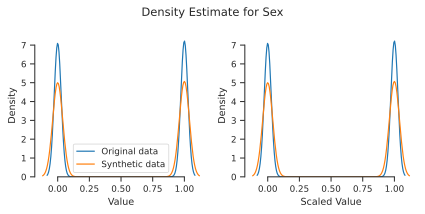

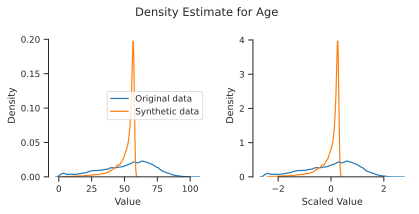

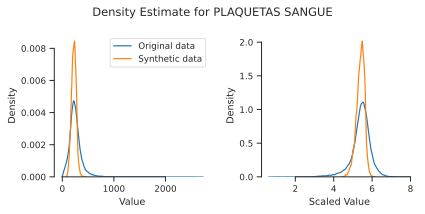

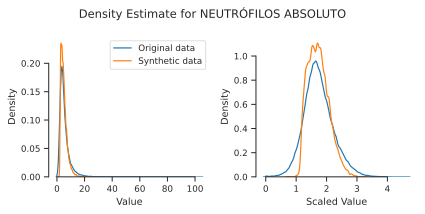

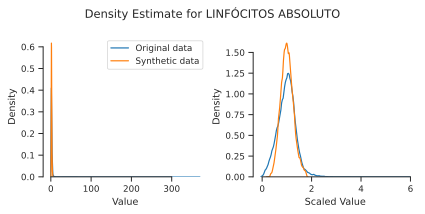

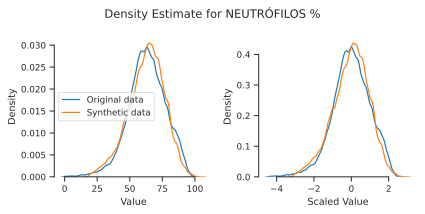

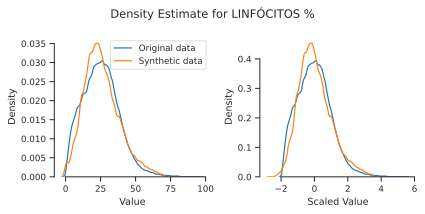

In [136]:
for i, t in enumerate(columns):
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    sns.kdeplot(df_agg[t], label='Original data', ax=ax[0], bw_adjust=0.5)
    sns.kdeplot(df_samples[t], label='Synthetic data', ax=ax[0], bw_adjust=0.5)
    ax[0].set_xlabel('Value')
    ax[0].set_ylabel('Density')
    ax[0].legend()

    sns.kdeplot(X_scaled[:,i], label='Original data', ax=ax[1], bw_adjust=0.5)
    sns.kdeplot(samples[:,i], label='Synthetic data', ax=ax[1], bw_adjust=0.5)
    ax[1].set_xlabel('Scaled Value')
    ax[1].set_ylabel('Density')

    plt.suptitle(f"Density Estimate for {t}")
    plt.tight_layout()
    sns.despine(trim=True)
    plt.savefig(f'./fig/VAE_dens_{i}.png')
    plt.show()

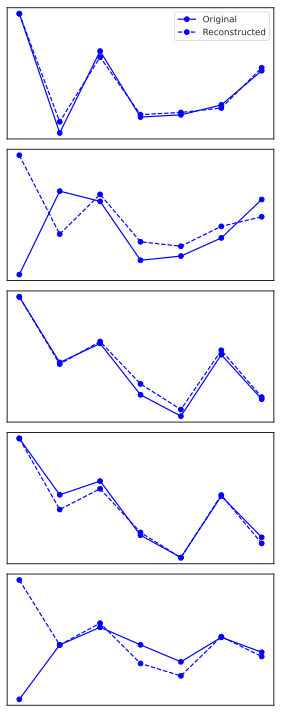

In [137]:
inputs = X_test[:5]
reconstruction_fig(model, inputs, scaler, scaled=True)
plt.savefig(f'./fig/VAE_recon.png')
plt.show()